# Face Recognition Model

## Setup

In [137]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import shutil
from pathlib import Path
import re
import uuid
from tensorflow.keras.metrics import Precision, Recall

In [138]:
# Model(inputs = [inputImg, veriImg], outputs = [1,0] )

In [139]:
gpus = tf.config.experimental.list_physical_devices('GPI')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [140]:
POS = os.path.join('data', 'positive')
NEG = os.path.join('data', 'negative')
ANC = os.path.join('data', 'anchor')

## Preprocess

### Data gathering

In [ ]:
def consolidate_images(source_dir):
    if not os.path.exists(source_dir):
        print(f"Creating directory: {source_dir}")
        os.makedirs(source_dir)

    subfolders = [f.path for f in os.scandir(source_dir) if f.is_dir()]
    
    if not subfolders:
        print(f"No subfolders found in {source_dir}")
        return

    image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp')
   
    copied_count = 0

    processed_folders = []
   
    for folder in subfolders:
        print(f"Processing folder: {folder}")
        folder_processed = False
       
        for root, dirs, files in os.walk(folder):
            for file in files:
                if file.lower().endswith(image_extensions):
                    source_path = os.path.join(root, file)
                    base_name = os.path.splitext(file)[0]
                    extension = os.path.splitext(file)[1]
                    counter = 1
                    dest_file = file
                   
                    while os.path.exists(os.path.join(source_dir, dest_file)):
                        dest_file = f"{base_name}_{counter}{extension}"
                        counter += 1
                   
                    dest_path = os.path.join(source_dir, dest_file)
                   
                    try:
                        shutil.copy2(source_path, dest_path)
                        copied_count += 1
                        folder_processed = True
                    except Exception as e:
                        print(f"Error copying {file}: {str(e)}")
        
        if folder_processed:
            processed_folders.append(folder)
    
    print(f"\nTotal images copied: {copied_count}")
    
    if processed_folders:
        print("\nDeleting processed folders:")
        for folder in processed_folders:
            try:
                shutil.rmtree(folder)
                print(f"Deleted: {folder}")
            except Exception as e:
                print(f"Error deleting {folder}: {str(e)}")

consolidate_images(NEG)

In [ ]:
# Correcting function because I messed up the top one and did it twice once with folder deleting and once without lol
def remove_duplicate_images(directory):
    if not os.path.exists(directory):
        print(f"Error: Directory '{directory}' does not exist.")
        return
    
    files = os.listdir(directory)
    files_to_delete = []
    pattern = re.compile(r'^(.+)_1(\.[^.]+)$')
    deleted_count = 0
    
    print(f"Scanning directory: {directory}")

    for file in files:
        match = pattern.match(file)
        if match:
            base_name = match.group(1)
            extension = match.group(2)
            original_file = f"{base_name}{extension}"
            if original_file in files:
                files_to_delete.append(file)

    for file in files_to_delete:
        try:
            file_path = os.path.join(directory, file)
            os.remove(file_path)
            print(f"Deleted: {file}")
            deleted_count += 1
        except Exception as e:
            print(f"Error deleting {file}: {str(e)}")
    
    print(f"\nTotal duplicate files deleted: {deleted_count}")

remove_duplicate_images(NEG)

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        print("Failed to grab frame")
        break

    frame = frame[120:120+250, 200:200+250, :]
    cv2.imshow('Image Collection', frame)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('a'):
        img_name = os.path.join(ANC, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(img_name, frame)
        print(f"Saved anchor image: {img_name}")
    elif key == ord('p'):
        img_name = os.path.join(POS, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(img_name, frame)
        print(f"Saved positive image: {img_name}")
    elif key == ord('q'):
        print("Quitting...")
        break
    
cap.release()
cv2.destroyAllWindows()

### Preprocess

In [68]:
anchor = tf.data.Dataset.list_files(ANC+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG+'\*.jpg').take(300)

<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
C:\Users\lokna\AppData\Local\Temp\ipykernel_31980\2097756147.py:1: SyntaxWarning: invalid escape sequence '\*'
  anchor = tf.data.Dataset.list_files(ANC+'\*.jpg').take(300)
C:\Users\lokna\AppData\Local\Temp\ipykernel_31980\2097756147.py:2: SyntaxWarning: invalid escape sequence '\*'
  positive = tf.data.Dataset.list_files(POS+'\*.jpg').take(300)
C:\Users\lokna\AppData\Local\Temp\ipykernel_31980\2097756147.py:3: SyntaxWarning: invalid escape sequence '\*'
  negative = tf.data.Dataset.list_files(NEG+'\*.jpg').take(300)


In [69]:
dir_test = anchor.as_numpy_iterator()

In [70]:
def preprocess(img_path):
    byte_img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(100,100))
    img = img/255
    return img

In [71]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [72]:
def preproc_twin(in_img, valid_img, label):
    return(preprocess(in_img), preprocess(valid_img), label)

In [73]:
data = data.map(preproc_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [74]:
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [75]:
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Model

### Building

In [107]:
def embeding_make():
    in_ = Input(shape=(100,100,3), name="in img")

    c1 = Conv2D(64, (10,10), activation='relu')(in_)
    p1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    c2 = Conv2D(128, (7,7), activation='relu')(p1)
    p2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation='relu')(p2)
    p3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    c4 = Conv2D(256, (4,4), activation='relu')(p3)
    f1 = Flatten()(c4)
    d1 = Dense(4096,activation='sigmoid')(f1)

    return Model(inputs=in_, outputs=d1, name='embedding')

In [108]:
embedding = embeding_make()

In [109]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, in_embed, valid_embed):
        return tf.math.abs(in_embed - valid_embed)

In [110]:
def make_model(): #Simanese
    input_img = Input(name='input_img', shape=(100,100,3))
    validation_img = Input(name='validation_img', shape=(100,100,3))

    model_layer = L1Dist()
    model_layer.name = 'distance'
    distances = model_layer(embedding(input_img), embedding(validation_img))

    classifier = Dense(1,activation='sigmoid')(distances)

    return Model(inputs=[input_img, validation_img], outputs=classifier, name='SimaneseNetwork')

In [118]:
siamese_model = make_model()

### Training

In [119]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoints = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoints, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [132]:
@tf.function
def t_step(batch):
    with tf.GradientTape() as tape:  
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [ ]:
def train(data, epochs):
    for epoch in range(1, epochs+1):
        print('\n Epoch {}/{}'.format(epoch, epochs))
        progbar = tf.keras.utils.Progbar(len(data))  
        for idx, batch in enumerate(data): 
            t_step(batch)
            progbar.update(idx+1)
        
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix) 

In [134]:
epochs = 50

In [136]:
train(train_data, epochs)


 Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step

 Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step

 Epoch 16/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step

 Epoch 17/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step

 Epoch 18/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step

 Epoch 19/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step

 

### Test / Evaluate model

In [142]:
test_in, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_in, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


In [143]:
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1]

In [144]:
y_true

array([0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.],
      dtype=float32)

In [145]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

np.float32(1.0)

In [147]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

np.float32(1.0)

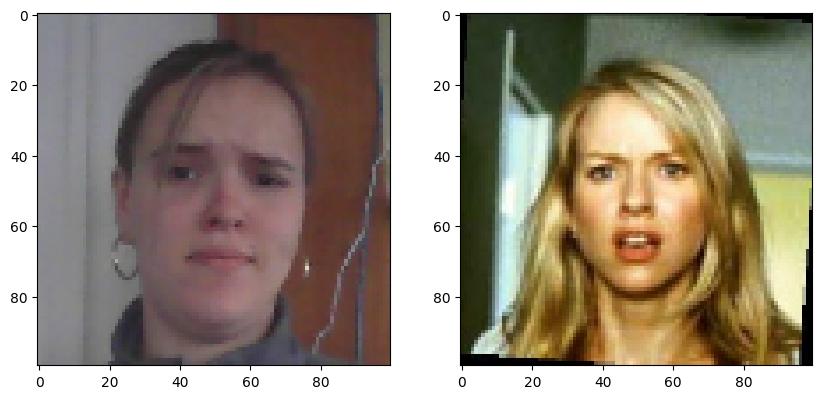

In [148]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_in[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()